# Visualization of the chemical space using Ersilia Compound Embeddings

In [4]:
from eosce import ErsiliaCompoundEmbeddings
import pandas as pd
import numpy as np
#from umap import UMAP
#import matplotlib.pyplot as plt
#import stylia
#from sklearn.decomposition import PCA

df = pd.read_csv('../data/data_0.csv')

In [11]:
inchikeys_list = df['InchiKey'].tolist()
smiles_list = df['Smiles'].tolist()
embedder = ErsiliaCompoundEmbeddings()
X = embedder.transform(smiles_list)

In [12]:
import csv
from tqdm import tqdm

with open("../assets/osm_ersilia_embeddings_index.csv", "w") as f:
    writer = csv.writer(f)
    for smi in tqdm(smiles_list):
        writer.writerow([smi])

with open("../assets/osm_ersilia_embeddings.csv", "w") as f:
    writer = csv.writer(f)
    for x in tqdm(X):
        writer.writerow(list(x))

100%|██████████| 405765/405765 [02:10<00:00, 3101.61it/s]


In [3]:
reducer_0 = PCA(n_components=0.9)
P_0 = reducer_0.fit_transform(X)

reducer_1 = UMAP(n_components=2)
P = reducer_1.fit_transform(P_0)

In [63]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm import tqdm
mw_list = [Descriptors.MolWt(Chem.MolFromSmiles(smiles)) for smiles in tqdm(smiles_list)]

In [80]:
import random
from tqdm import tqdm

example_smiles_by_phase = []
all_phases = ["data_0.csv", "data_1.csv", "data_2.csv", "data_3.csv", "data_4.csv", "data_5.csv", "data_6.csv", "data_7.csv", "data_8.csv", "data_9.csv", "data_10.csv", "data_11.csv", "data_12.csv", "data_13.csv", "eosi_s4_candidates_90.csv"]
for i in tqdm(range(len(all_phases)-1)):
    df_cur = pd.read_csv(f'../data/{all_phases[i]}')
    df_new = pd.read_csv(f'../data/{all_phases[i+1]}')
    df_diff = df_cur[~df_cur['InchiKey'].isin(df_new['InchiKey'])]
    smis = df_diff['Smiles'].tolist()
    example_smiles_by_phase += [random.sample(smis, 5)]
df_cur = pd.read_csv(f'../data/{all_phases[-1]}')
example_smiles_by_phase += [random.sample(df_cur['Smiles'].tolist(), 5)]
example_smiles_by_phase = np.array(example_smiles_by_phase)

d = {"phase": all_phases}
for i in range(example_smiles_by_phase.shape[1]):
    d[f"example_{i}"] = example_smiles_by_phase[:,i]
de = pd.DataFrame(d)
de.to_csv('../assets/example_smiles_by_phase.csv', index=False)

100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


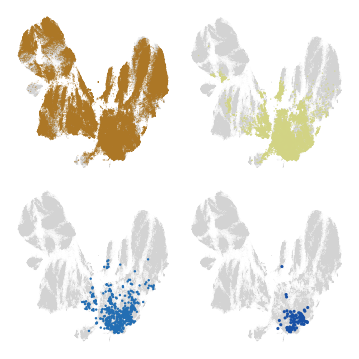

In [99]:
phase_descriptions = [
    "Generated compounds",
    "Triazolopyrazine core",
    "Physicochemical properties",
    "Synthetic feasibility",
    "Dissimilarity to existing S4",
    "Predicted active (class.)",
    "Predicted IC50 < 10uM",
    "Scaffold redundancy",
    "Filter out low activities (I)",
    "Filter out low activities (II)",
    "Remove redundancy",
    "Filter out low overall scores",
    "Filter out low MAIP scores",
    "Filter out low activity (III)",
    "Final selection"
]

15it [00:01,  9.63it/s]
/var/folders/yw/xtwk9yf95pn1k634kvjphtsh0000gn/T/ipykernel_48616/312451439.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/Users/mduranfrigola/miniconda3/envs/osms4/lib/python3.11/site-packages/stylia/figure/__init__.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


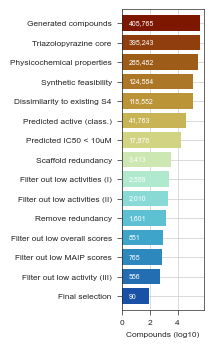

In [108]:
from stylia.colors.colors import NamedColors, ContinuousColorMap

fig, axs = stylia.create_figure(1, 1, height=stylia.TWO_COLUMNS_WIDTH*0.55, width=stylia.TWO_COLUMNS_WIDTH*0.15)
ax = axs.next()
cmap_phases = ContinuousColorMap()
cmap_phases.fit([0, len(all_phases)])
colors_phases = cmap_phases.transform(np.arange(len(all_phases)))

x = []
y = []
for i, phase in tqdm(enumerate(all_phases)):
    dp = pd.read_csv(f'../data/{phase}')
    y += [len(dp)]
    x += [i]

ax.barh(x, np.log10(y), color=colors_phases, edgecolor="none")
for i, n in zip(x,y):
    ax.text(0.5, i, "{0:,}".format(n), ha="left", va="center", color="white")
ax.set_yticks(x)
ax.set_yticklabels(phase_descriptions)
ax.set_ylim(len(all_phases)-0.3, -0.7)

stylia.label(ax=ax, title="", xlabel="Compounds (log10)", ylabel="")
plt.tight_layout()
stylia.save_figure("../assets/phases.png")

In [ ]:
named_colors = NamedColors()
cmap = ContinuousColorMap()
cmap.fit([400, 500])

def get_idxs_from_inchikeys(inchikeys, inchikeys_list):
    iks_dict = {ik: i for i, ik in enumerate(inchikeys_list)}
    idxs = []
    for inchikey in inchikeys:
        idxs.append(iks_dict[inchikey])
    return idxs

def projection_plot(ax, P, idxs, color):
    ax.scatter(P[:,0], P[:,1], s=0.01, color=named_colors.gray, edgecolor="none", alpha=0.5)
    if len(idxs) > 100000:
        s = 0.5
        alpha = 0.5
    elif len(idxs) > 10000:
        s = 1
        alpha = 0.8
    elif len(idxs) > 100:
        s = 3
        alpha = 1
    else:
        s = 5
        alpha = 1
    if idxs is not None:
        ax.scatter(P[idxs,0], P[idxs,1], s=s, color=color, edgecolors="none", alpha=alpha)
    ax.axis("off")
    stylia.label(ax=ax, title="")
    return ax

fig, axs = stylia.create_figure(2, 2, height=stylia.TWO_COLUMNS_WIDTH*0.5, width=stylia.TWO_COLUMNS_WIDTH*0.5)

# desired synthetic accessibility
ax = axs.next()

dc = pd.read_csv("../data/data_3.csv")
idxs = get_idxs_from_inchikeys(dc['InchiKey'].tolist(), inchikeys_list)
projection_plot(ax, P, idxs, colors_phases[all_phases.index("data_3.csv")])

# predicted high activity
ax = axs.next()
dc = pd.read_csv("../data/data_6.csv")
idxs = get_idxs_from_inchikeys(dc['InchiKey'].tolist(), inchikeys_list)
projection_plot(ax, P, idxs, colors_phases[all_phases.index("data_6.csv")])

# selection by activity of other models
ax = axs.next()
dc = pd.read_csv("../data/data_13.csv")
idxs = get_idxs_from_inchikeys(dc['InchiKey'].tolist(), inchikeys_list)
projection_plot(ax, P, idxs, colors_phases[all_phases.index("data_13.csv")])

# final selection of 90 compounds
ax = axs.next()
dc = pd.read_csv("../data/eosi_s4_candidates_90.csv")
idxs = get_idxs_from_inchikeys(dc['InchiKey'].tolist(), inchikeys_list)
projection_plot(ax, P, idxs, colors_phases[all_phases.index("eosi_s4_candidates_90.csv")])

plt.tight_layout()
stylia.save_figure("../assets/projections_plots.png")

In [2]:
df = pd.read_csv('../data/data_13.csv')

In [23]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
IsTriazoloPyrazine,556.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
TriazoloHeteroaryl,556.0,0.868705,0.338027,0.000000,1.000000,1.000000,1.000000,1.000000
TriazoloPhenyl,556.0,0.821942,0.382906,0.000000,1.000000,1.000000,1.000000,1.000000
TriazoloHeteroarylPara,556.0,0.776978,0.416648,0.000000,1.000000,1.000000,1.000000,1.000000
TriazoloHeteroarylMeta,556.0,0.275180,0.447007,0.000000,0.000000,0.000000,1.000000,1.000000
TriazoloHeteroarylOrto,556.0,0.109712,0.312812,0.000000,0.000000,0.000000,0.000000,1.000000
TriazoloNaphthalene,556.0,0.001799,0.042409,0.000000,0.000000,0.000000,0.000000,1.000000
PyrazineEther,556.0,0.868705,0.338027,0.000000,1.000000,1.000000,1.000000,1.000000
PyrazineAmide,556.0,0.032374,0.177151,0.000000,0.000000,0.000000,0.000000,1.000000
MolWt,556.0,457.088567,25.817924,380.398000,440.370750,457.409000,476.463500,531.466000


In [24]:
all_phases = ["data_0.csv", "data_1.csv", "data_2.csv", "data_3.csv", "data_4.csv", "data_5.csv", "data_6.csv", "data_7.csv", "data_8.csv", "data_9.csv", "data_10.csv", "data_11.csv", "data_12.csv", "data_13.csv", "eosi_s4_candidates_90.csv"]

In [60]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm import tqdm

MW = []
LogP = []
Num = []

for phase in all_phases:
    print(phase)
    df = pd.read_csv(f'../data/{phase}')
    smiles = df['Smiles'].tolist()
    mols = [Chem.MolFromSmiles(smi) for smi in tqdm(smiles)]
    mw = np.array([Descriptors.MolWt(mol) for mol in tqdm(mols)])
    logp = np.array([Descriptors.MolLogP(mol) for mol in tqdm(mols)])
    MW += [{"mean": mw.mean(), "std": mw.std(), "p5": np.percentile(mw, 5), "p95": np.percentile(mw, 95), "p25": np.percentile(mw, 25), "p75": np.percentile(mw, 75), "p50": np.percentile(mw, 50)}]
    LogP += [{"mean": logp.mean(), "std": logp.std(), "p5": np.percentile(logp, 5), "p95": np.percentile(logp, 95), "p25": np.percentile(logp, 25), "p75": np.percentile(logp, 75), "p50": np.percentile(logp, 50)}]
    Num += [{"n": df.shape[0], "log10n": np.log10(df.shape[0])}]


data_0.csv


100%|██████████| 405765/405765 [01:30<00:00, 4487.80it/s]


data_1.csv


100%|██████████| 395243/395243 [01:31<00:00, 4337.51it/s]


data_2.csv


100%|██████████| 285482/285482 [01:08<00:00, 4158.62it/s]


data_3.csv


100%|██████████| 124584/124584 [00:27<00:00, 4582.99it/s]


data_4.csv


100%|██████████| 118552/118552 [00:25<00:00, 4687.36it/s]


data_5.csv


100%|██████████| 41763/41763 [00:09<00:00, 4598.81it/s]


data_6.csv


100%|██████████| 17876/17876 [00:03<00:00, 4758.92it/s]


data_7.csv


100%|██████████| 3413/3413 [00:00<00:00, 4631.76it/s]


data_8.csv


100%|██████████| 2559/2559 [00:00<00:00, 4734.59it/s]


data_9.csv


100%|██████████| 2010/2010 [00:00<00:00, 4721.22it/s]


data_10.csv


100%|██████████| 1601/1601 [00:00<00:00, 4744.42it/s]


data_11.csv


100%|██████████| 851/851 [00:00<00:00, 4897.51it/s]


data_12.csv


100%|██████████| 765/765 [00:00<00:00, 4768.59it/s]


data_13.csv


100%|██████████| 556/556 [00:00<00:00, 4821.87it/s]


eosi_s4_candidates_90.csv


100%|██████████| 90/90 [00:00<00:00, 4663.16it/s]


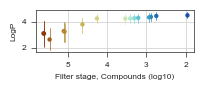

In [62]:
fig, axs = stylia.create_figure(1, 1, height=stylia.TWO_COLUMNS_WIDTH*0.12, width=stylia.TWO_COLUMNS_WIDTH*0.28)

cmap_phases = ContinuousColorMap()
cmap_phases.fit([0, len(all_phases)])
colors_phases = cmap_phases.transform(np.arange(len(all_phases)))

def evolution_plot(ax, xvals, yvals):
    x = [d["log10n"] for d in xvals]
    y = [d["p50"] for d in yvals]
    ub = [d["p75"] for d in yvals]
    lw = [d["p25"] for d in yvals]
    ax.scatter(x, y, color=colors_phases, edgecolor="none", s=10)
    for u, l, i in zip(ub, lw, range(len(x))):
        ax.plot([x[i], x[i]], [u, l], color=colors_phases[i])
    ax.set_xlim(5.8, 1.8)
    stylia.label(ax=ax, title="", xlabel="Filter stage, Compounds (log10)", ylabel="LogP")

ax = axs.next()

evolution_plot(ax, Num, LogP)
plt.tight_layout()

stylia.save_figure("../assets/evolution_props.png")

In [9]:
from stylia.colors.colors import NamedColors, ContinuousColorMap

named_colors = NamedColors()

[1, 142, 403, 10]
[265, 35, 2, 170, 84]
[483, 18, 55]


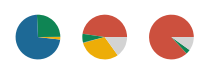

In [20]:
fig, axs = stylia.create_figure(1,3, height=stylia.TWO_COLUMNS_WIDTH*0.1, width=stylia.TWO_COLUMNS_WIDTH*0.3)

pie_colors = [named_colors.red, named_colors.green, named_colors.blue, named_colors.yellow, named_colors.gray]

# pie chart number of rings
ax = axs.next()
num_rings = np.array(df["NumRings"])

x = [np.sum(num_rings==3), np.sum(num_rings==4), np.sum(num_rings==5), np.sum(num_rings==6)]
print(x)
ax.pie(x, wedgeprops={"edgecolor":"none"}, colors=pie_colors[:len(x)])
stylia.label(ax=ax, title="", xlabel="", ylabel="")

# pie chart heteroaryl
ax = axs.next()

dh = df[["TriazoloHeteroarylPara", "TriazoloHeteroarylMeta", "TriazoloHeteroarylOrto"]]
counts_none = 0
counts_para = 0
counts_meta = 0
counts_orto = 0
counts_mult = 0
for v in dh.values:
    if np.sum(v) == 0:
        counts_none += 1
    elif np.sum(v) > 1:
        counts_mult += 1
    elif v[0] == 1:
        counts_para += 1
    elif v[1] == 1:
        counts_meta += 1
    elif v[2] == 1:
        counts_orto += 1
    else:
        print(v)
x = [counts_para, counts_meta, counts_orto, counts_mult, counts_none]
print(x)
ax.pie(x, wedgeprops={"edgecolor":"none"}, colors=pie_colors)

stylia.label(ax=ax, title="", xlabel="", ylabel="")

# pie chart pyrazine
ax = axs.next()

dh = df[["PyrazineEther", "PyrazineAmide"]]
counts_none = 0
counts_ether = 0
counts_amide = 0
for v in dh.values:
    if np.sum(v) == 0:
        counts_none += 1
    elif np.sum(v) > 1:
        print(v)
    elif v[0] == 1:
        counts_ether += 1
    elif v[1] == 1:
        counts_amide += 1
    else:
        print(v)

x = [counts_ether, counts_amide, counts_none]
print(x)
ax.pie(x, wedgeprops={"edgecolor":"none"}, colors=[pie_colors[0], pie_colors[1], pie_colors[-1]])
stylia.label(ax=ax, title="", xlabel="", ylabel="")

plt.tight_layout()
stylia.save_figure("../assets/pie_charts.png")

# North-East and North-West Substituents discriminative analysis

In [78]:
from rdkit import Chem
import pandas as pd
from tqdm import tqdm

# Define the SMILES for the target molecule and the pattern to subtract
sub_pattern = "c1cnccn1"
full_pattern = "c2cn1cnnc1cn2"

from rdkit import Chem

def get_substituent(smiles):

    # Define your molecule and core structure
    mol_smiles = smiles  # Example molecule
    core_smiles = 'c2cn1cnnc1cn2'    # Core to remove

    # Convert SMILES to RDKit molecule objects
    mol = Chem.MolFromSmiles(mol_smiles)
    core = Chem.MolFromSmiles(core_smiles)

    # Perform the core removal, replacing the core with uniquely labeled dummy atoms
    fragments = Chem.ReplaceCore(mol, core, replaceDummies=True, labelByIndex=True)
    frag_list = Chem.GetMolFrags(fragments, asMols=True, sanitizeFrags=True)

    if len(frag_list) != 2:
        return None
    
    frag_0 = Chem.MolToSmiles(frag_list[0])
    frag_1 = Chem.MolToSmiles(frag_list[1])

    if "[3*]" in frag_0 and "[1*]" in frag_1:
        return {"ne": frag_0.replace("[3*]", "[*]"), "nw": frag_1.replace("[1*]", "[*]")}
    if "[3*]" in frag_1 and "[1*]" in frag_0:
        return {"ne": frag_1.replace("[3*]", "[*]"), "nw": frag_0.replace("[1*]", "[*]")}
    return None


di = pd.read_csv("../data/data_4.csv")[["InchiKey", "Smiles"]]
do = pd.read_csv("../data/data_6.csv")[["InchiKey", "Smiles"]]
di = di[~di["InchiKey"].isin(do["InchiKey"])]

Ri = []
for v in tqdm(di.values):
    try:
        s = get_substituent(v[1])
    except:
        continue
    if s is not None:
        Ri += [[v[0], v[1], s["nw"], s["ne"]]]

Ro = []
for v in tqdm(do.values):
    try:
        s = get_substituent(v[1])
    except:
        continue
    if s is not None:
        Ro += [[v[0], v[1], s["nw"], s["ne"]]]

di = pd.DataFrame(Ri, columns = ["InchiKey", "Smiles", "NW", "NE"])
do = pd.DataFrame(Ro, columns = ["InchiKey", "Smiles", "NW", "NE"])

di.to_csv("../assets/substituents_before.csv", index=False)
do.to_csv("../assets/substituents_after.csv", index=False)

100%|██████████| 17876/17876 [00:05<00:00, 3102.54it/s]


In [81]:
di = pd.read_csv("../assets/substituents_before.csv")
do = pd.read_csv("../assets/substituents_after.csv")

In [85]:
from statsmodels.stats.proportion import proportions_ztest

def enrichment_factor(smiles, column):
    ni = di[di[column] == smiles].shape[0]
    no = do[do[column] == smiles].shape[0]
    fi = ni / di.shape[0] + 1e-120
    fo = no / do.shape[0] + 1e-120
    z, p = proportions_ztest([no, ni], [do.shape[0], di.shape[0]])
    return {"smiles": smiles, "ni": ni, "no": no, "fi": fi, "fo": fo, "fc": fo/fi, "z": z, "p": p}



In [123]:
value_counts = do.value_counts("NW")
abundant_smiles = value_counts[value_counts > 10].index.tolist()

for smi in abundant_smiles[:10000]:
    results = enrichment_factor(smi, "NW")
    if results["fc"] < 100:
        continue
    print(results)

{'smiles': '[*]OCc1ccc(Cl)c(C(F)(F)F)c1', 'ni': 6, 'no': 127, 'fi': 5.964096141229796e-05, 'fo': 0.0071096680288865255, 'fc': 119.20780384034038, 'z': 25.929216703319756, 'p': 3.1199304463193898e-148}
{'smiles': '[*]OCc1cc(C(F)(F)F)ccc1F', 'ni': 3, 'no': 72, 'fi': 2.982048070614898e-05, 'fo': 0.004030677937636455, 'fc': 135.1647539607009, 'z': 19.59027229148739, 'p': 1.8718650463943305e-85}
{'smiles': '[*]OCc1ccc(C(F)(F)F)c(F)c1', 'ni': 2, 'no': 71, 'fi': 1.988032047076599e-05, 'fo': 0.003974696299613727, 'fc': 199.93119856687008, 'z': 19.62814273235646, 'p': 8.890557001847957e-86}
{'smiles': '[*]OCc1cc(F)cc(C(F)(F)F)c1', 'ni': 1, 'no': 30, 'fi': 9.940160235382994e-06, 'fo': 0.0016794491406818563, 'fc': 168.9559424508761, 'z': 12.712918116846781, 'p': 5.012828902339408e-37}
{'smiles': '[*]OCCc1ccc(C(F)(F)F)cc1F', 'ni': 1, 'no': 28, 'fi': 9.940160235382994e-06, 'fo': 0.0015674858646363993, 'fc': 157.69221295415105, 'z': 12.262399771810903, 'p': 1.4416622116151298e-34}
{'smiles': '[*]OCc

In [108]:
value_counts = do.value_counts("NE")
abundant_smiles = value_counts[value_counts > 10].index.tolist()

for smi in abundant_smiles[:100]:
    results = enrichment_factor(smi, "NE")
    if results["fc"] < 50:
        continue
    print(results)

{'smiles': '[*]c1ccc(C(F)(F)OC)cc1', 'ni': 5, 'no': 76, 'fi': 4.9700801176914974e-05, 'fo': 0.004254604489727369, 'fc': 85.60434417511055, 'z': 19.81265030891259, 'p': 2.3156802487713795e-87}
{'smiles': '[*]c1ccc(C(F)(F)F)cc1OC', 'ni': 4, 'no': 50, 'fi': 3.976064094153198e-05, 'fo': 0.0027990819011364273, 'fc': 70.39830935453172, 'z': 15.92153363588609, 'p': 4.4922922716844015e-57}
{'smiles': '[*]c1ccc(C(C)(O)C(F)(F)F)cc1', 'ni': 3, 'no': 36, 'fi': 2.982048070614898e-05, 'fo': 0.0020153389688182277, 'fc': 67.58237698035045, 'z': 13.480116246192557, 'p': 2.0478394117893718e-41}
{'smiles': '[*]c1ccc(C(C)(C)O)c(F)c1F', 'ni': 3, 'no': 35, 'fi': 2.982048070614898e-05, 'fo': 0.001959357330795499, 'fc': 65.70508873089628, 'z': 13.27123839881564, 'p': 3.399164078515815e-40}
{'smiles': '[*]c1ccc(CO)cc1C', 'ni': 3, 'no': 27, 'fi': 2.982048070614898e-05, 'fo': 0.0015115042266136706, 'fc': 50.68678273526283, 'z': 11.469127823884154, 'p': 1.8855002498316235e-30}
{'smiles': '[*]c1ccc(C(F)OC(F)F)cc1'

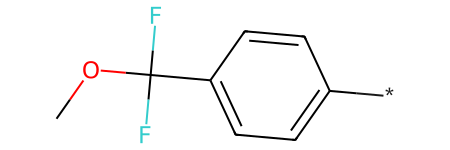

In [114]:
Chem.MolFromSmiles("[*]c1ccc(C(F)(F)OC)cc1")

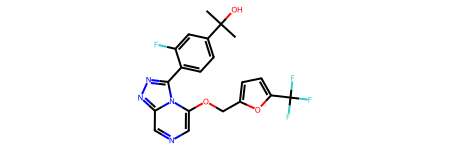

In [103]:
Chem.MolFromSmiles(do[do["NE"] == "[*]c1ccc(C(C)(C)O)cc1F"]["Smiles"].tolist()[0])

In [97]:
Chem.MolFromSmiles(do[do["NW" == "[*]OCc1ccc(C(F)(F)F)cc1"]]["Smiles"].tolist()[0])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/mduranfrigola/miniconda3/envs/ersilia/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3790, in get_loc
    --------
  File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 181, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: False

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/mduranfrigola/miniconda3/envs/ersilia/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/gl/qqtyyls96rvdkjyk_03q18c00000gn/T/ipykernel_21728/4078585595.py", line 1, in <module>
    Chem.MolFromSmile

In [51]:
get_substituent(do[do["NW"] == "CC(C)(O)c1ccccc1"]["Smiles"].tolist()[0])

{'nw': 'CC(C)(O)c1ccccc1', 'ne': 'OCCC(O)(C#Cc1ccco1)C(F)(F)F'}

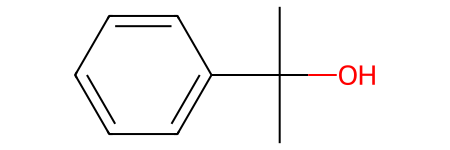

In [50]:
Chem.MolFromSmiles("CC(C)(O)c1ccccc1")

In [76]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions

def get_fragments(smiles):

    # Define your molecule and core structure
    mol_smiles = smiles  # Example molecule
    core_smiles = 'c2cn1cnnc1cn2'    # Core to remove

    # Convert SMILES to RDKit molecule objects
    mol = Chem.MolFromSmiles(mol_smiles)
    core = Chem.MolFromSmiles(core_smiles)

    # Perform the core removal, replacing the core with uniquely labeled dummy atoms
    fragments = Chem.ReplaceCore(mol, core, replaceDummies=True, labelByIndex=True)
    frag_list = Chem.GetMolFrags(fragments, asMols=True, sanitizeFrags=True)

    if len(frag_list) != 2:
        return None
    
    frag_0 = Chem.MolToSmiles(frag_list[0])
    frag_1 = Chem.MolToSmiles(frag_list[1])

    if "[3*]" in frag_0 and "[1*]" in frag_1:
        return {"ne": frag_0.replace("[3*]", "[*]"), "nw": frag_1.replace("[1*]", "[*]")}
    if "[3*]" in frag_1 and "[1*]" in frag_0:
        return {"ne": frag_1.replace("[3*]", "[*]"), "nw": frag_0.replace("[1*]", "[*]")}
    return None


get_fragments(do[do["NW"] == "CC(C)(O)c1ccccc1"]["Smiles"].tolist()[0])

{'ne': '[*]c1ccc(C(C)(C)O)cc1', 'nw': '[*]OCCC(O)(C#Cc1ccco1)C(F)(F)F'}

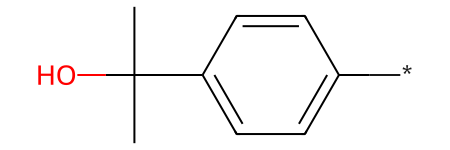

In [77]:
Chem.MolFromSmiles('[*]c1ccc(C(C)(C)O)cc1')

In [74]:
Chem.MolToSmiles(frag_list[0])

'[3*]c1ccc(C(C)(C)O)cc1'

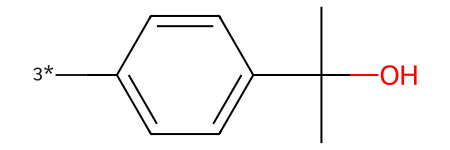

In [55]:
fragments = Chem.ReplaceCore(mol, core, replaceDummies=True, labelByIndex=True)

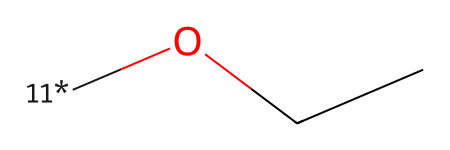

In [56]:
fragments